In [77]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import os

# List contents of MyDrive
print("Contents of '/content/drive/MyDrive/':")
for item in os.listdir('/content/drive/MyDrive/'):
    print(item)

Contents of '/content/drive/MyDrive/':
FL_Lung_Cancer
Lung Dataset
FL_VGG19.ipynb


In [80]:
train_dir = '/content/drive/MyDrive/Lung Dataset'
test_dir = '/content/drive/MyDrive/Lung Dataset'

In [81]:
import os

# List contents of the nested 'Lung Dataset' directory
nested_lung_dataset_path = '/content/drive/MyDrive/Lung Dataset'
print(f"Contents of '{nested_lung_dataset_path}':")
if os.path.exists(nested_lung_dataset_path):
    for item in os.listdir(nested_lung_dataset_path):
        print(item)
else:
    print(f"Path does not exist: {nested_lung_dataset_path}")

Contents of '/content/drive/MyDrive/Lung Dataset':
Benign
Malignant
Normal


In [82]:
import os

# List contents of the 'Lung Dataset' directory
lung_dataset_base_path = '/content/drive/MyDrive/Lung Dataset/'
print(f"Contents of '{lung_dataset_base_path}':")
if os.path.exists(lung_dataset_base_path):
    for item in os.listdir(lung_dataset_base_path):
        print(item)
else:
    print(f"Path does not exist: {lung_dataset_base_path}")

Contents of '/content/drive/MyDrive/Lung Dataset/':
Benign
Malignant
Normal


In [83]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

In [84]:
data_paths = []
data_labels = []

for label in os.listdir(train_dir):
    for img_file in os.listdir(os.path.join(train_dir, label)):
        data_paths.append(os.path.join(train_dir, label, img_file))
        data_labels.append(label)

data_paths, data_labels = shuffle(data_paths, data_labels, random_state=42)

train_paths, test_paths, train_labels, test_labels = train_test_split(data_paths, data_labels, test_size=0.2, random_state=42, stratify=data_labels)

print(f"Total images: {len(data_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

Total images: 1097
Training images: 877
Testing images: 220


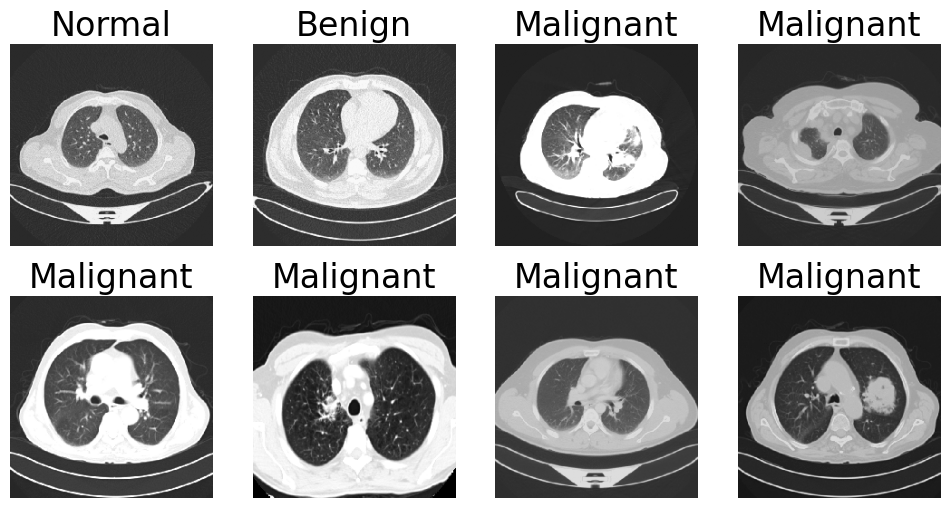

In [85]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [86]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [87]:
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [88]:

# Define the base model from MobileNet
base_model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable except the last few for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
# MobileNet often benefits from fine-tuning the top convolutional blocks
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Define the input layer explicitly
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add the MobileNet base model
x = base_model(input_layer)

# Add additional layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(unique_labels), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

In [89]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 1,994,243 (7.61 MB)

 Non-trainable params: 1,366,208 (5.21 MB)

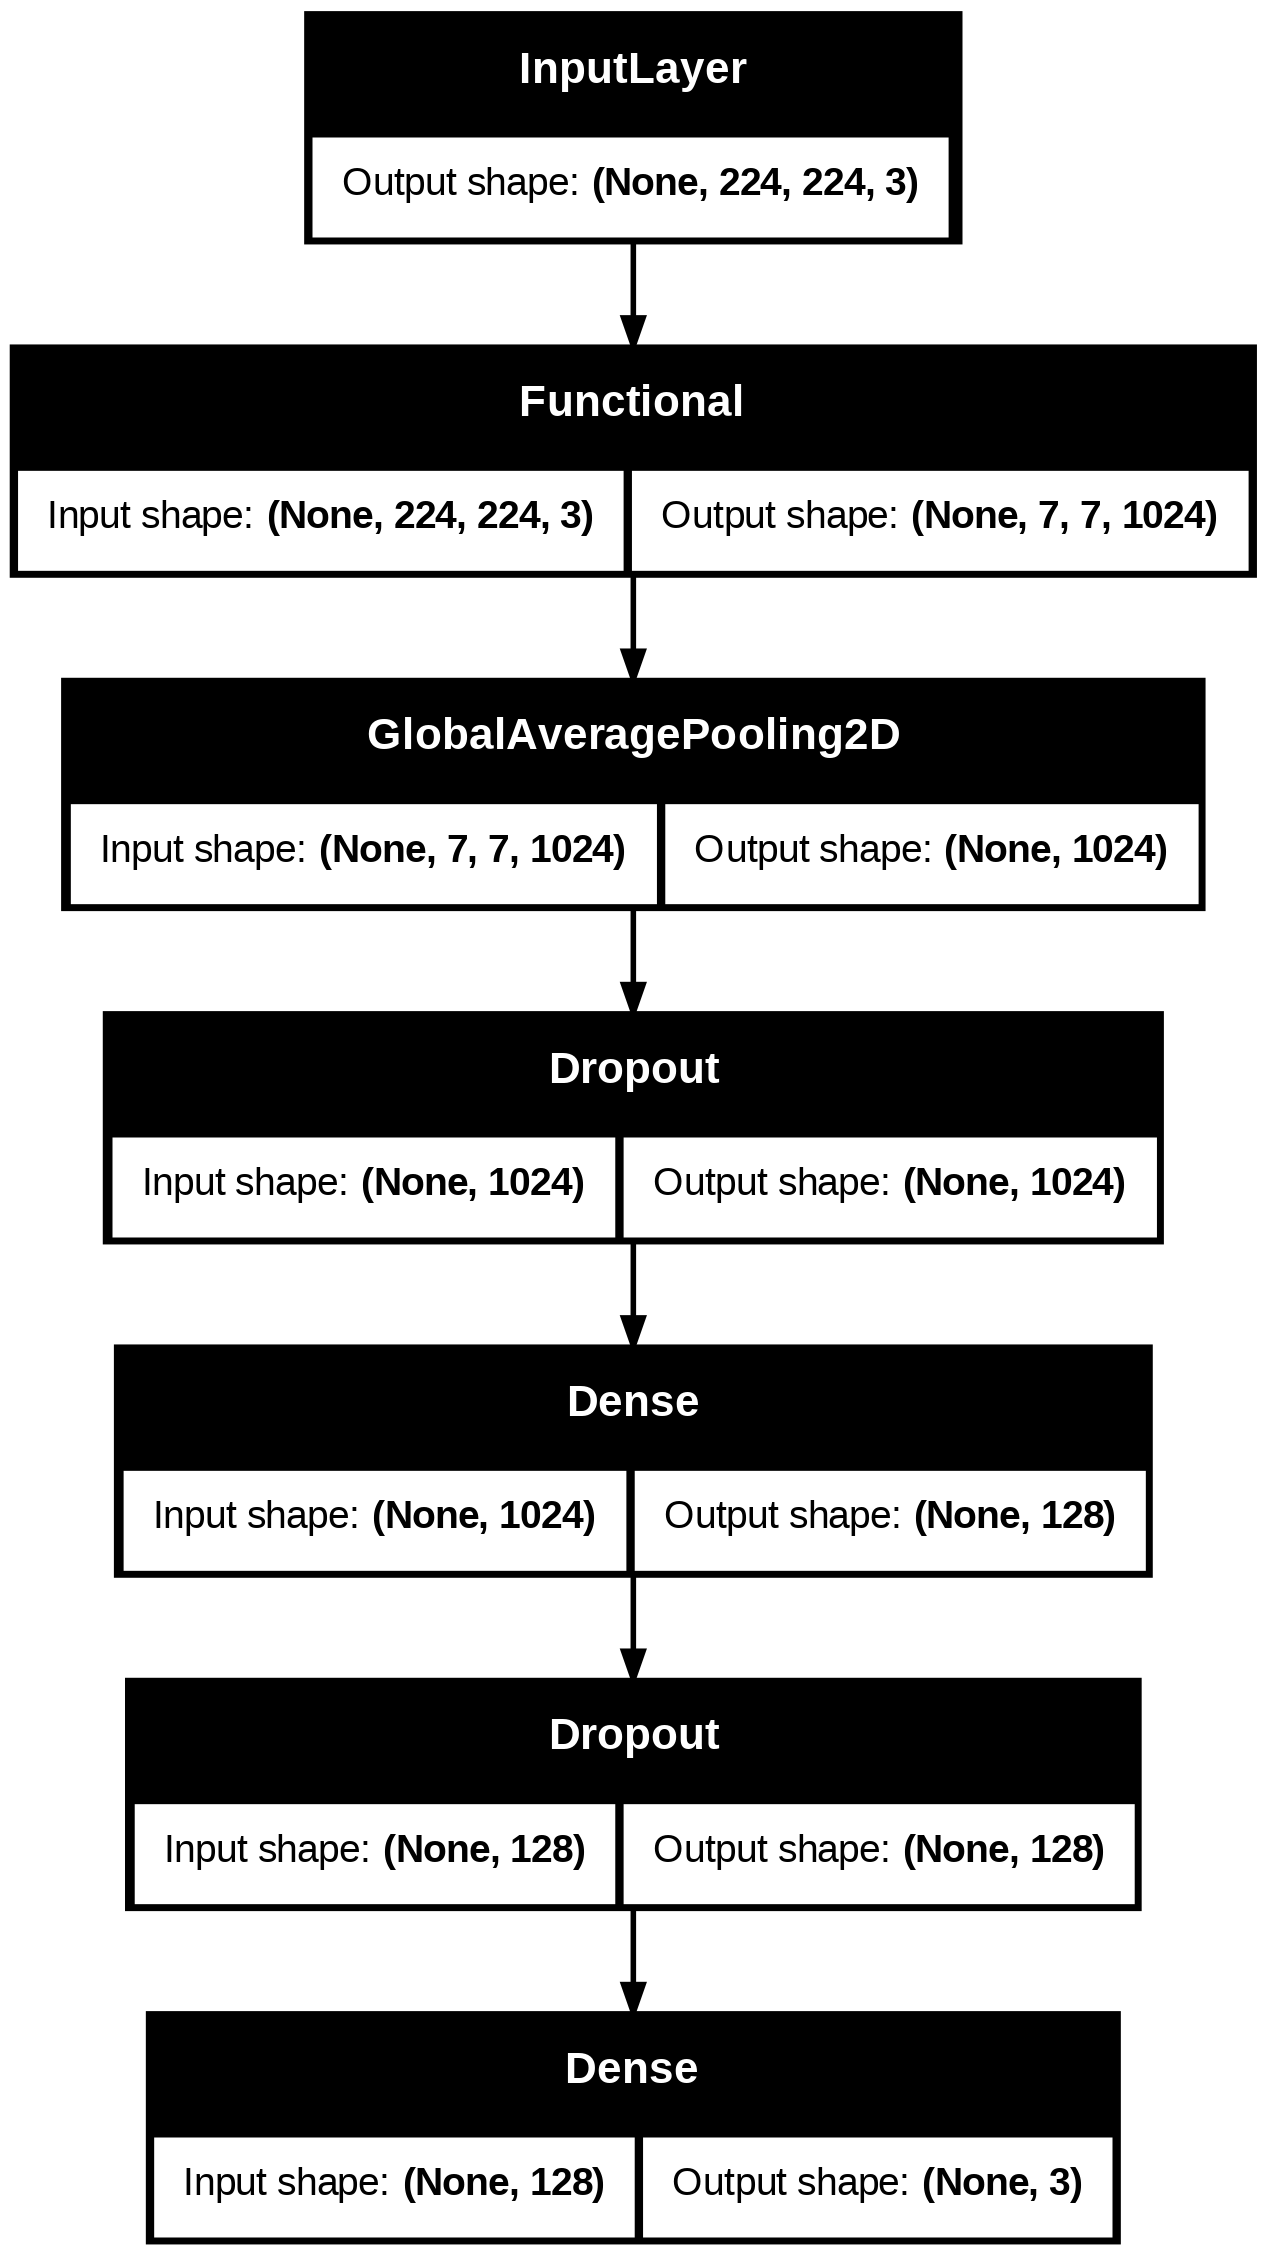

In [90]:
keras.utils.plot_model(model, show_shapes=True)

In [91]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [92]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.9839 - sparse_categorical_accuracy: 0.6319
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.2653 - sparse_categorical_accuracy: 0.8912
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.1332 - sparse_categorical_accuracy: 0.9501
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.1052 - sparse_categorical_accuracy: 0.9620
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9721
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9898
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9883
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9898
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9999
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.0129 - spars

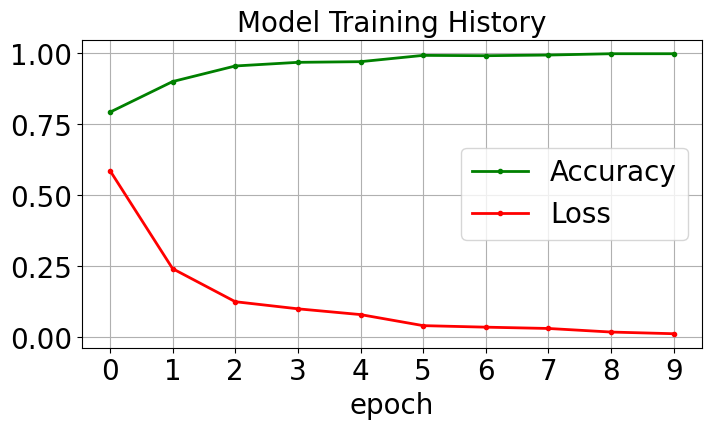

In [93]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='center right', fontsize =20)
plt.show()

# Federated Learning Based transfer Learning enabled MobileNet Model

In [94]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9980
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0104 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9925
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0215 - sparse_categorical_accuracy: 0.9886
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0095 - sparse_categorical_accuracy: 1.0000
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9888
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9945
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0094 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0029 - sparse_categoric

  0%|          | 0/6 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7e1f31617d80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 17%|█▋        | 1/6 [00:02<00:14,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 2/6 [00:04<00:08,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 3/6 [00:06<00:05,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 67%|██████▋   | 4/6 [00:09<00:04,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 5/6 [00:11<00:02,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|██████████| 6/6 [00:12<00:00,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


7it [00:14,  2.07s/it]


In [96]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       1.00      0.21      0.34        24
   Malignant       1.00      0.96      0.98       113
      Normal       0.78      1.00      0.88        83

    accuracy                           0.90       220
   macro avg       0.93      0.72      0.74       220
weighted avg       0.92      0.90      0.87       220



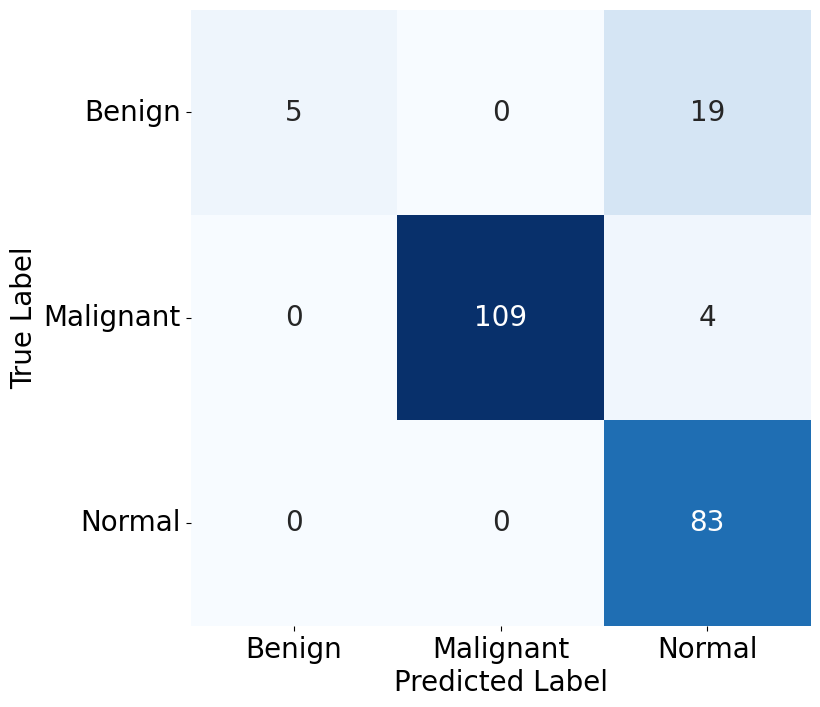

In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [101]:
# Assuming 'Malignant' (index 1) is the positive class for these calculations

TP = cm[1, 1]
FP = cm[0, 1] + cm[2, 1] # Sum of predictions as Malignant, where true is Benign (0) or Normal (2)
FN = cm[1, 0] + cm[1, 2] # Sum of true Malignant, where predicted as Benign (0) or Normal (2)
TN = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2] # Sum of true Not Malignant, predicted as Not Malignant

print(f'For Malignant Class (Positive):')
print(f'  TP: {TP:f}')
print(f'  TN: {TN:f}')
print(f'  FP: {FP:f}')
print(f'  FN: {FN:f}')

For Malignant Class (Positive):
  TP: 109.000000
  TN: 107.000000
  FP: 0.000000
  FN: 4.000000


In [102]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.98182
Specificity: 1.00000
 Recall: 0.96460
 Precision: 1.00000
F1 Score: 0.98198


In [106]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

# The TP, TN, FP, FN values are already calculated from the model's confusion matrix
# Using the previously calculated values:
# TP = TP
# TN = TN
# FP = FP
# FN = FN

# Generate labels and predictions for AUC, MCC, Kappa using the calculated values
# For binary classification where 1 is the positive class
y_true = np.array([1] * int(TP) + [0] * int(TN) + [1] * int(FN) + [0] * int(FP))  # True labels
y_pred = np.array([1] * int(TP) + [0] * int(TN) + [0] * int(FN) + [1] * int(FP))  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")

AUC: 0.82511
MCC: 0.73548
Cohen's Kappa: 0.72282


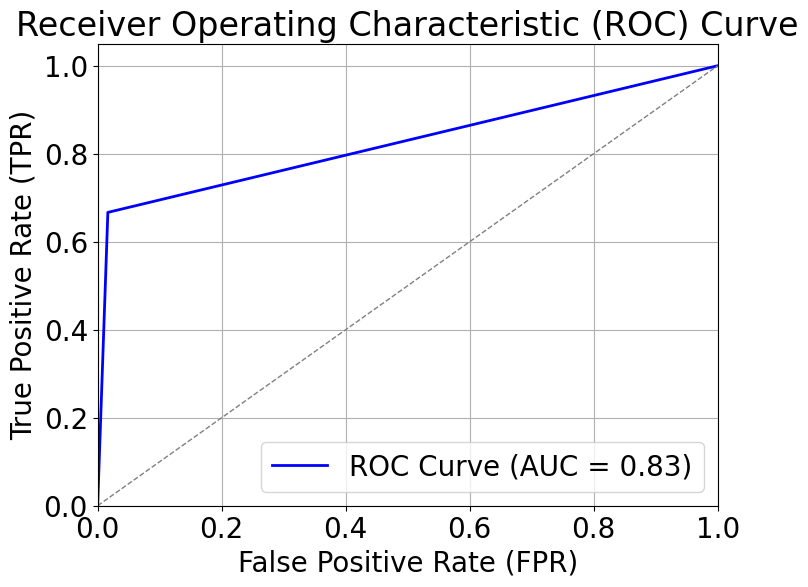

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

# Improved Code of Transfer Learning Based MobileNet Model

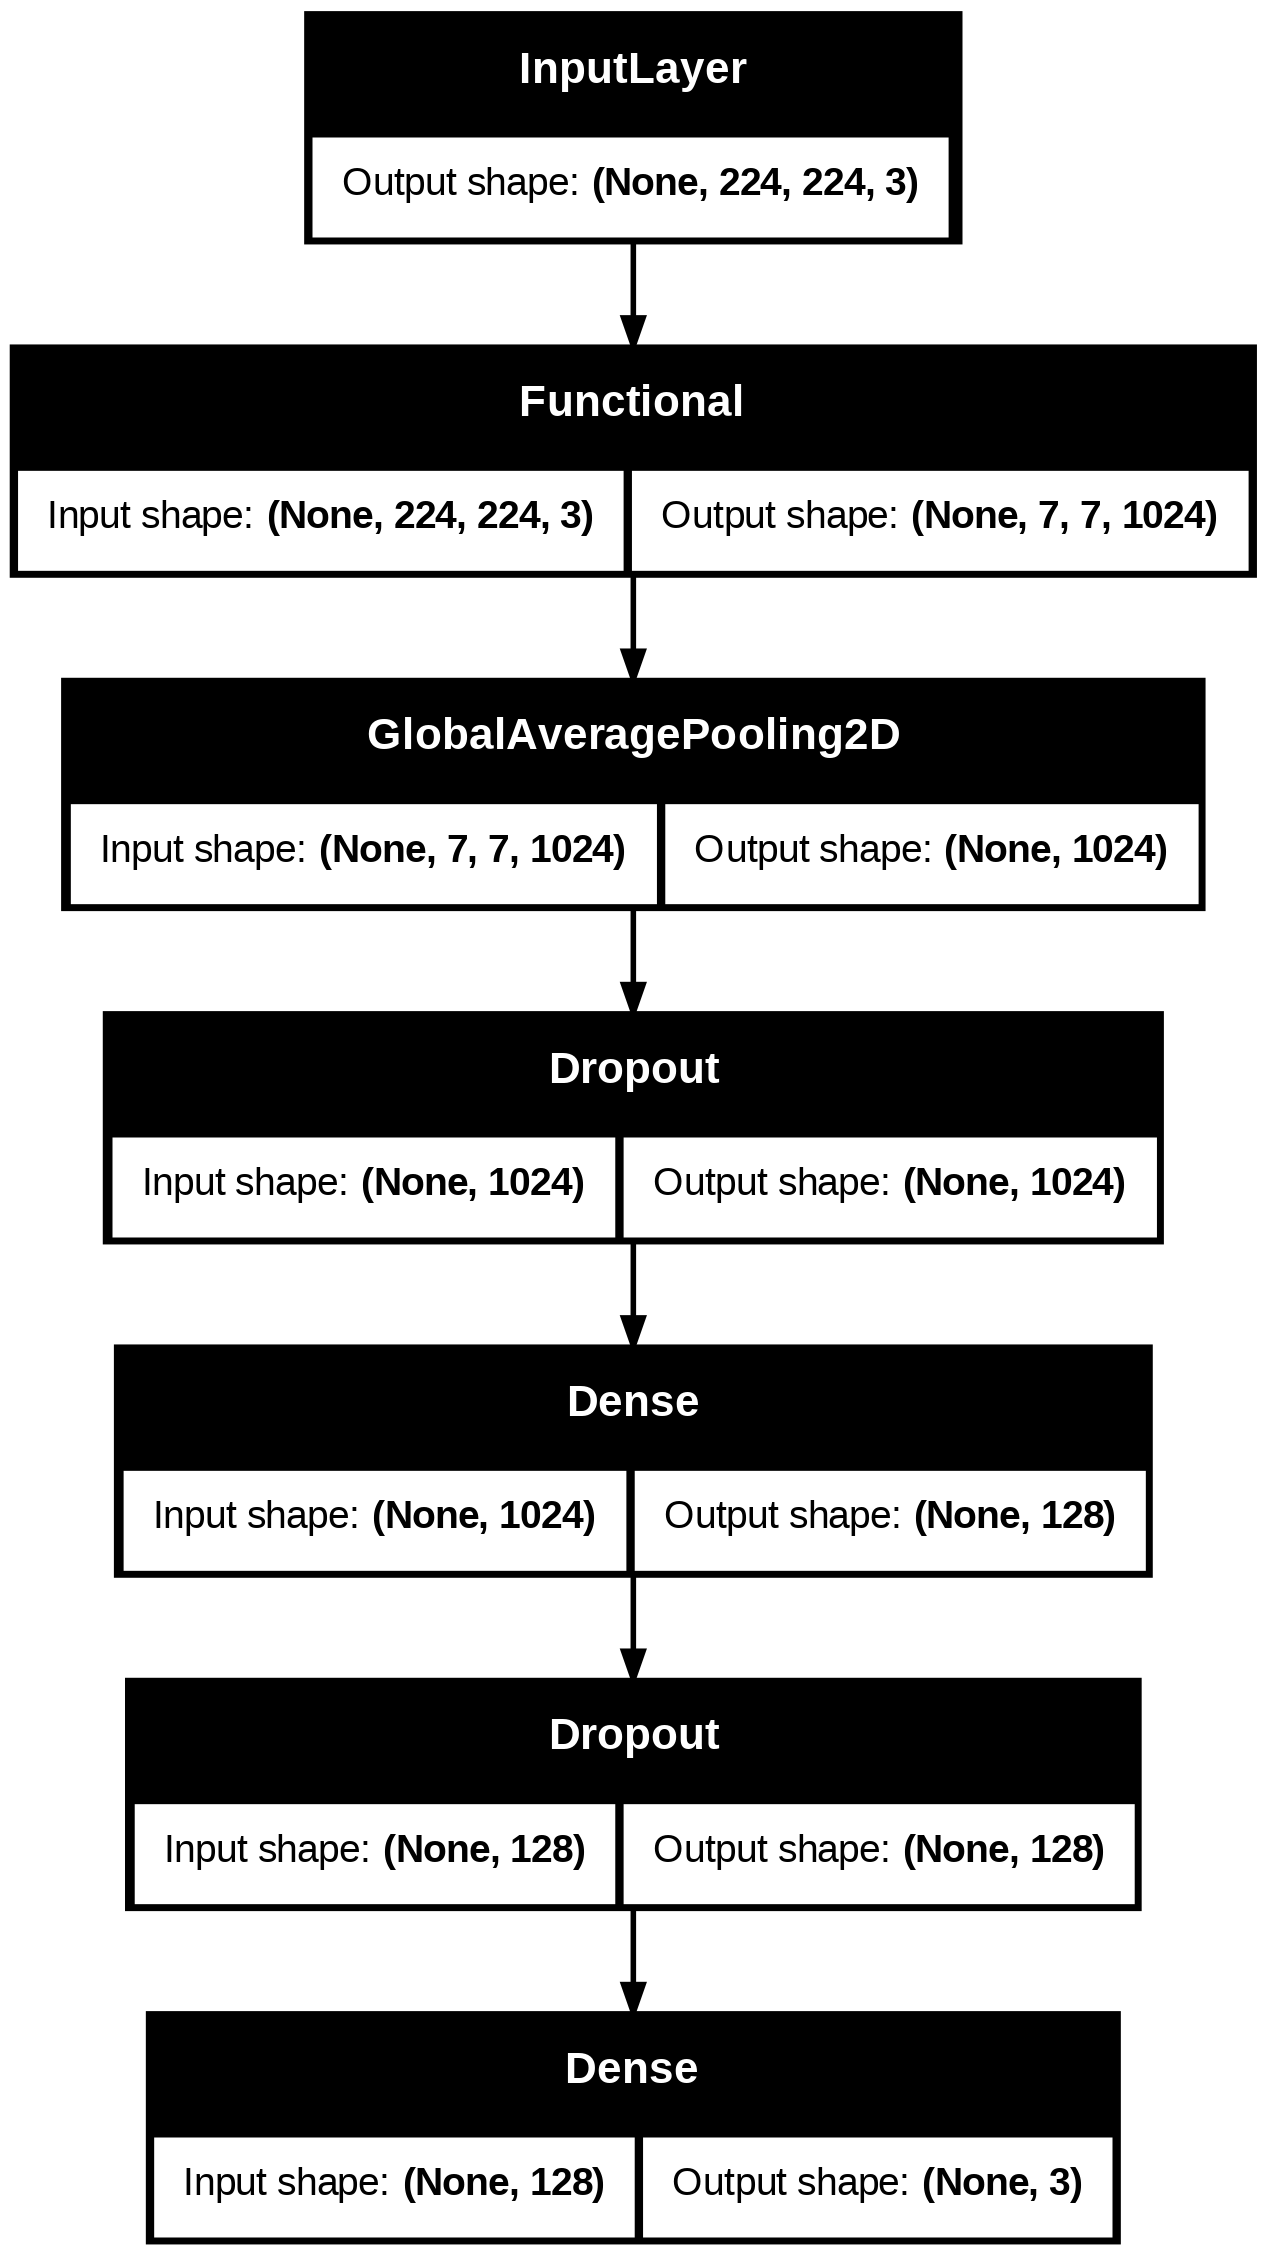

In [110]:
keras.utils.plot_model(model, show_shapes=True)

In [111]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [112]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9992
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9955
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0033 - sparse_categorical_accuracy: 0.9999
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9994
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0075 - sparse_categorical_accuracy: 0.9986
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.0054 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.0038 - sparse_categorical_accuracy: 0.9982
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0034 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0035 - sparse_categorical_accuracy: 0.9997
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.0044 - spars

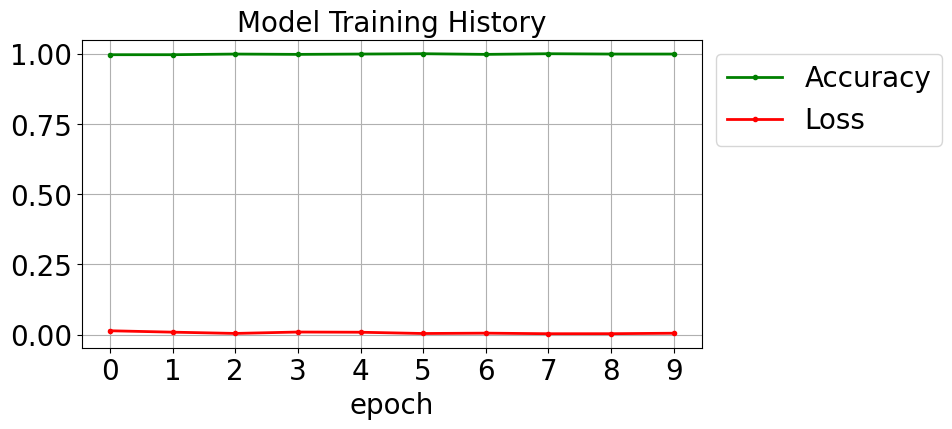

In [113]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [114]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/6 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7e1f2195f600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 17%|█▋        | 1/6 [00:05<00:28,  5.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 2/6 [00:07<00:13,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 3/6 [00:09<00:07,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 4/6 [00:10<00:04,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 5/6 [00:12<00:01,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████| 6/6 [00:14<00:00,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


7it [00:17,  2.48s/it]


In [116]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.61      0.96      0.74        24
   Malignant       0.97      1.00      0.99       113
      Normal       0.98      0.78      0.87        83

    accuracy                           0.91       220
   macro avg       0.85      0.91      0.87       220
weighted avg       0.94      0.91      0.92       220



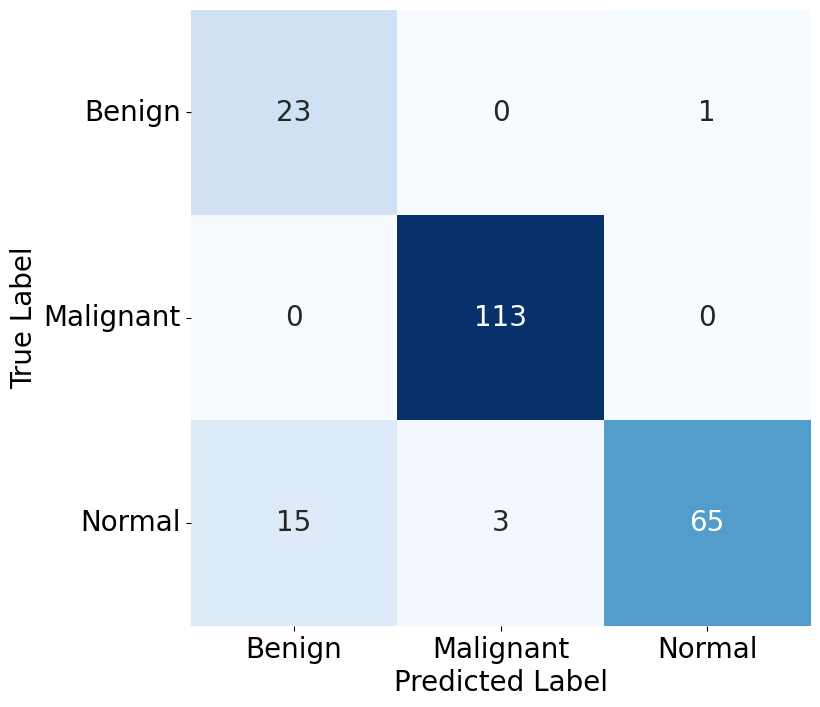

In [118]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [122]:
import numpy as np
from sklearn.metrics import roc_curve, auc,roc_auc_score

# Assuming 'Malignant' (index 1) is the positive class for these calculations
TP = cm[1, 1]
FP = cm[0, 1] + cm[2, 1] # Sum of predictions as Malignant, where true is Benign (0) or Normal (2)
FN = cm[1, 0] + cm[1, 2] # Sum of true Malignant, where predicted as Benign (0) or Normal (2)
TN = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2] # Sum of true Not Malignant, predicted as Not Malignant

print(f'For Malignant Class (Positive):')
print(f'  TP: {TP:f}')
print(f'  TN: {TN:f}')
print(f'  FP: {FP:f}')
print(f'  FN: {FN:f}')

acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


For Malignant Class (Positive):
  TP: 113.000000
  TN: 104.000000
  FP: 3.000000
  FN: 0.000000
acc: 0.98636
Specificity: 0.97196
 Recall: 1.00000
 Precision: 0.97414
F1 Score: 0.98690
